## Setup Environments

### Mount Drive and Setup Project Directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
project_dir="your-project-directory"

In [3]:
project_dir="/content/drive/MyDrive/Colab Notebooks/Classical Deep Learning Implements"

In [4]:
%cd {project_dir}

/content/drive/MyDrive/Colab Notebooks/Classical Deep Learning Implements


In [5]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Classical Deep Learning Implements


In [6]:
# GPU Check
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, f"({torch.cuda.get_device_name(0)})" if torch.cuda.is_available() else "")

Using device: cuda (NVIDIA A100-SXM4-40GB)


In [7]:
!nvidia-smi

Tue May 27 03:36:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             46W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Import Libraries

In [41]:
import os
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## CIFAR-10 Dataset

In [42]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Classical Deep Learning Implements


In [43]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]


# Transforms (Resize to 227x227 for AlexNet)
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [44]:
# Load CIFAR-10
cifar10_trainval = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
cifar10_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

In [45]:
# Split train/val (90% train, 10% val)
train_size = int(0.9 * len(cifar10_trainval))
val_size = len(cifar10_trainval) - train_size
train_dataset, val_dataset = random_split(cifar10_trainval, [train_size, val_size])

In [46]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [47]:
print(f"Dataset Split:\n - Train: {len(train_dataset)}\n - Val: {len(val_dataset)}\n - Test: {len(cifar10_test)}")

Dataset Split:
 - Train: 45000
 - Val: 5000
 - Test: 10000


### Display CIFAR-10 Dataset

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as F

def show_cifar10_before_after_from_transformed(dataset, class_names, num_images=5):
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32).reshape(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32).reshape(3, 1, 1)

    plt.figure(figsize=(num_images * 2.5, 5))

    for i in range(num_images):
        # ดึงภาพจากชุดที่ผ่าน transform แล้ว (227×227)
        img_transformed, label = dataset[i]

        # ย้อน normalize
        img_after = img_transformed * std + mean

        # สร้าง "Before" = resize กลับเป็น 32×32 เพื่อเปรียบเทียบ
        img_before = F.resize(img_after, [32, 32])  # ย้อนขนาดเฉย ๆ

        # Convert เป็น numpy
        img_before_np = img_before.permute(1, 2, 0).numpy()
        img_after_np = img_after.permute(1, 2, 0).numpy()

        # Before
        plt.subplot(2, num_images, i + 1)
        plt.imshow(np.clip(img_before_np, 0, 1))
        plt.title(f"Before\n({class_names[label]})")
        plt.axis("off")

        # After
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(np.clip(img_after_np, 0, 1))
        plt.title("After (Resized+Norm)")
        plt.axis("off")

    plt.suptitle("CIFAR-10: Before vs After (from Transformed Dataset)", fontsize=15)
    plt.tight_layout()
    plt.show()

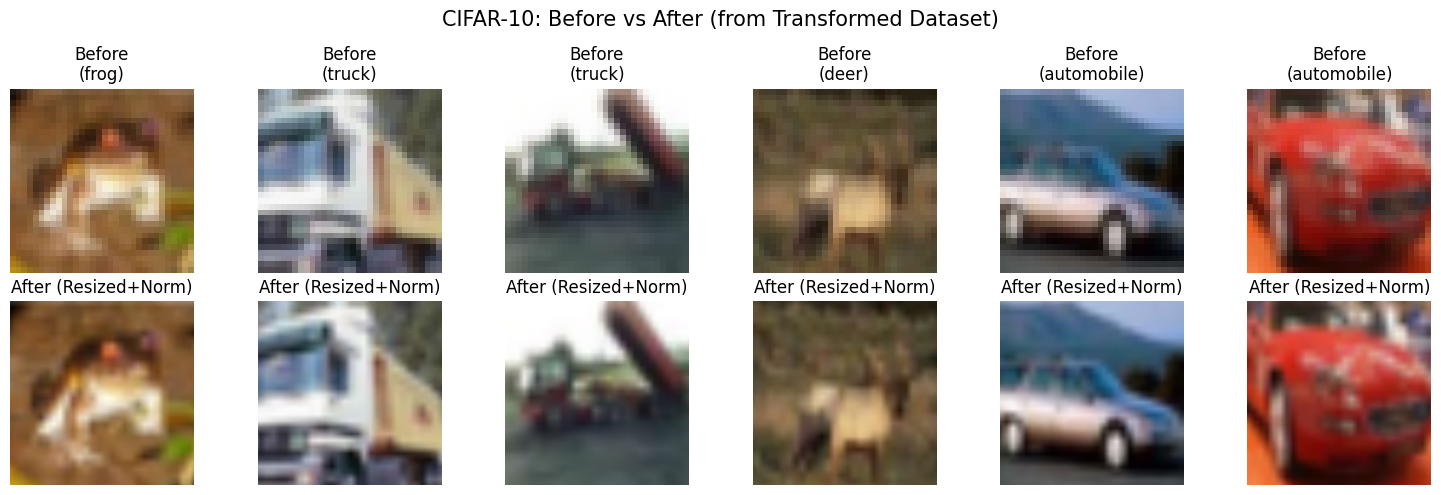

In [49]:
show_cifar10_before_after_from_transformed(cifar10_trainval, class_names, num_images=6)

### Data Loader

In [50]:
from torch.utils.data import DataLoader

# Create loaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(cifar10_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Define AlexNet

In [51]:
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):  # CIFAR 10 classes
        super(AlexNet, self).__init__()

        # Feature Extractor (Backbone)
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),  # input: (3, 227, 227) → output: (96, 55, 55)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # → (96, 27, 27)

            nn.Conv2d(96, 256, kernel_size=5, padding=2),           # → (256, 27, 27)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # → (256, 13, 13)

            nn.Conv2d(256, 384, kernel_size=3, padding=1),          # → (384, 13, 13)
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),          # → (384, 13, 13)
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),          # → (256, 13, 13)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)                   # → (256, 6, 6)
        )

        # Classifier (Fully Connected)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # flatten from (B, 256, 6, 6) → (B, 9216)
        x = self.classifier(x)
        return x

In [52]:
# Create a Model and move to GPU
model = AlexNet(num_classes=10).to(device) # move to GPU

#### Model Summary

In [53]:
!pip install -q torchsummary

In [54]:
from torchsummary import summary
summary(model, input_size=(3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]       1,327,488
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

###  Visualize Feature Maps (Convolution Layer)

In [55]:
def visualize_feature_maps_with_input(model, data_loader, device, num_channels=8):
    model.eval()

    # เอาภาพตัวอย่างจาก DataLoader
    images, labels = next(iter(data_loader))
    image = images[0].unsqueeze(0).to(device)  # เอาภาพเดียว

    # แสดงภาพต้นฉบับ (หลัง transform แล้ว)
    unnorm = lambda x: x * 0.5 + 0.5
    input_img = unnorm(images[0]).permute(1, 2, 0).numpy()

    plt.figure(figsize=(3, 3))
    plt.imshow(np.clip(input_img, 0, 1))
    plt.title("Input Image (Resized + Normalized)")
    plt.axis('off')
    plt.show()

    # ส่งภาพผ่านแต่ละชั้น
    x = image
    for idx, layer in enumerate(model.features):
        x = layer(x)

        if isinstance(layer, nn.Conv2d):
            print(f"Layer {idx}: {layer.__class__.__name__} → Shape: {x.shape}")

            fmap = x.detach().cpu().squeeze(0)  # Shape: (C, H, W)

            plt.figure(figsize=(15, 3))
            for i in range(min(num_channels, fmap.shape[0])):
                plt.subplot(1, num_channels, i + 1)
                plt.imshow(fmap[i], cmap='viridis')
                plt.title(f"Channel {i}")
                plt.axis('off')

            plt.suptitle(f"Feature Map after Conv Layer {idx}", fontsize=14)
            plt.tight_layout()
            plt.show()

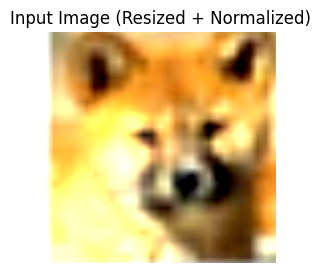

Layer 0: Conv2d → Shape: torch.Size([1, 96, 55, 55])


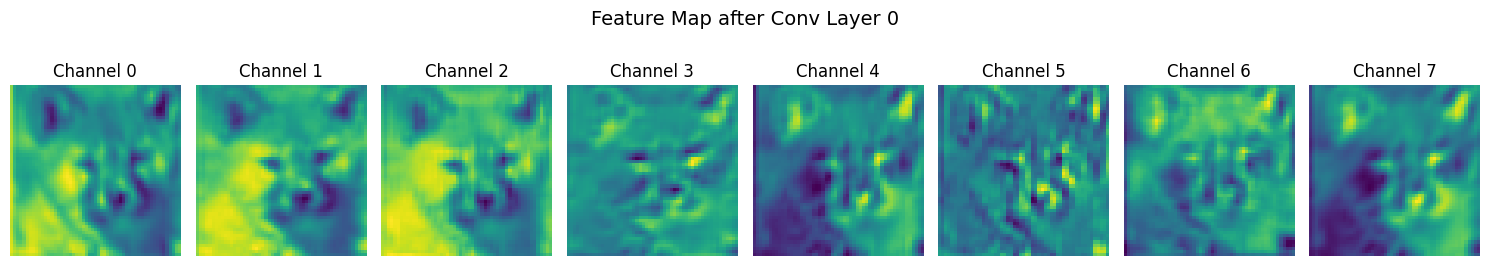

Layer 3: Conv2d → Shape: torch.Size([1, 256, 27, 27])


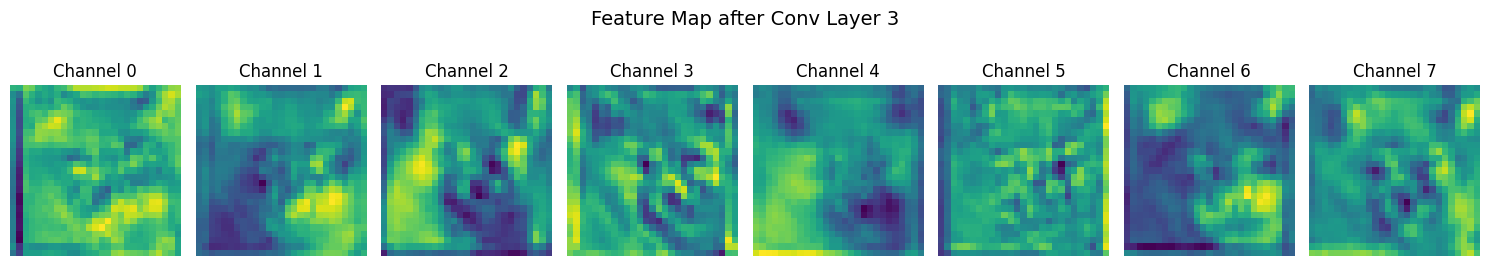

Layer 6: Conv2d → Shape: torch.Size([1, 384, 13, 13])


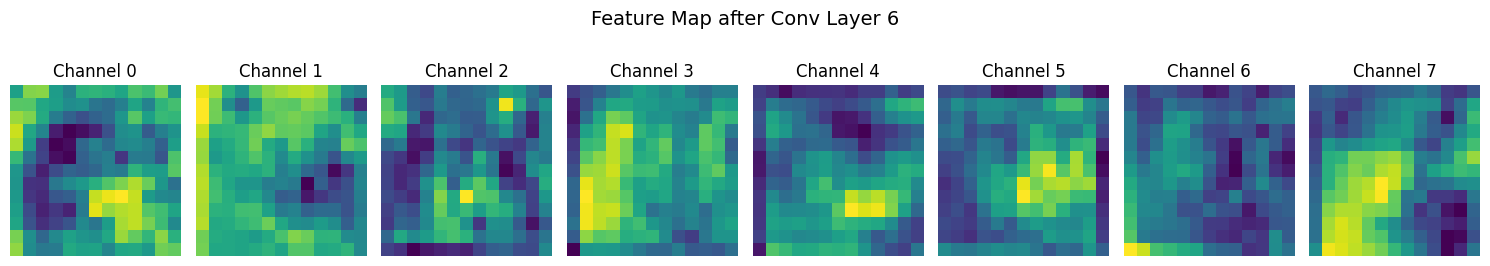

Layer 8: Conv2d → Shape: torch.Size([1, 384, 13, 13])


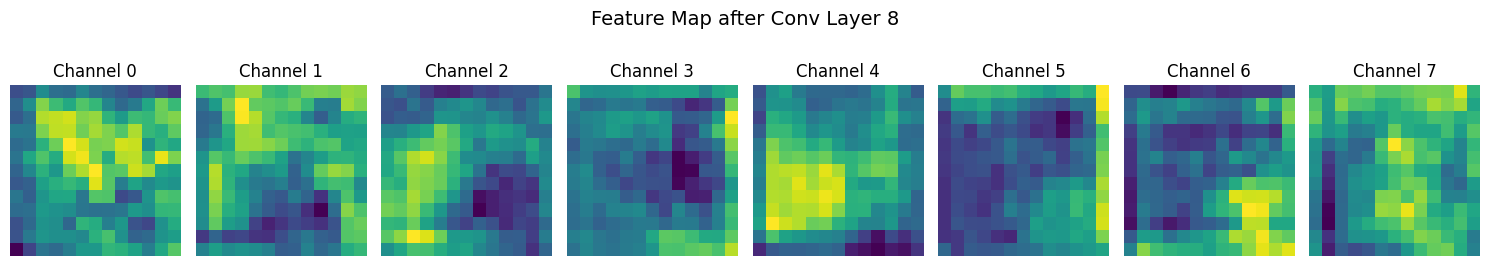

Layer 10: Conv2d → Shape: torch.Size([1, 256, 13, 13])


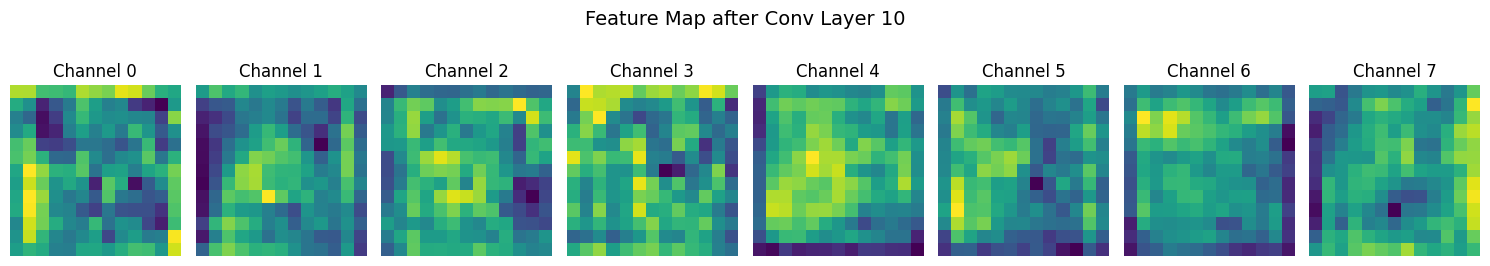

In [75]:
visualize_feature_maps_with_input(model, train_loader, device)

## Training Loop

In [24]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
import time

```
CrossEntropy = -log(softmax(predicted_class_score))
```

In [25]:
# Set up training params
EPOCHS = 60
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [26]:
# Logging
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [27]:
# EarlyStopping config
best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0

In [28]:
start_time = time.time()

for epoch in range(EPOCHS):

    # Training Loop
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation Loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"\nEpoch {epoch+1} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

    # 💡 EarlyStopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "./saved_models/alex_best_model.pth")  # Save best model
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

total_time = time.time() - start_time
print(f"Training Completed in {total_time:.2f} seconds.")


Epoch 1/60: 100%|██████████| 704/704 [00:44<00:00, 15.91it/s, acc=29.2, loss=2]



Epoch 1 - Train Loss: 1.8908, Train Acc: 29.18% | Val Loss: 1.6459, Val Acc: 40.44%



Epoch 2/60: 100%|██████████| 704/704 [00:43<00:00, 16.01it/s, acc=50, loss=1.17]



Epoch 2 - Train Loss: 1.3703, Train Acc: 50.03% | Val Loss: 1.2559, Val Acc: 56.16%



Epoch 3/60: 100%|██████████| 704/704 [00:44<00:00, 15.92it/s, acc=61.7, loss=1.01]



Epoch 3 - Train Loss: 1.0788, Train Acc: 61.75% | Val Loss: 0.9489, Val Acc: 65.72%



Epoch 4/60: 100%|██████████| 704/704 [00:44<00:00, 15.98it/s, acc=68.3, loss=0.453]



Epoch 4 - Train Loss: 0.9069, Train Acc: 68.28% | Val Loss: 0.8547, Val Acc: 71.42%



Epoch 5/60: 100%|██████████| 704/704 [00:43<00:00, 16.04it/s, acc=72, loss=0.608]



Epoch 5 - Train Loss: 0.8035, Train Acc: 71.95% | Val Loss: 0.8348, Val Acc: 71.60%



Epoch 6/60: 100%|██████████| 704/704 [00:43<00:00, 16.09it/s, acc=75, loss=0.242]



Epoch 6 - Train Loss: 0.7186, Train Acc: 75.04% | Val Loss: 0.7284, Val Acc: 75.06%



Epoch 7/60: 100%|██████████| 704/704 [00:43<00:00, 16.03it/s, acc=77.1, loss=0.749]



Epoch 7 - Train Loss: 0.6618, Train Acc: 77.07% | Val Loss: 0.6832, Val Acc: 76.44%



Epoch 8/60: 100%|██████████| 704/704 [00:43<00:00, 16.00it/s, acc=79, loss=0.514]



Epoch 8 - Train Loss: 0.6115, Train Acc: 78.97% | Val Loss: 0.6610, Val Acc: 77.50%



Epoch 9/60: 100%|██████████| 704/704 [00:44<00:00, 15.89it/s, acc=80.5, loss=0.302]



Epoch 9 - Train Loss: 0.5665, Train Acc: 80.50% | Val Loss: 0.6746, Val Acc: 77.22%

No improvement for 1 epochs


Epoch 10/60: 100%|██████████| 704/704 [00:44<00:00, 15.89it/s, acc=81.7, loss=1.72]



Epoch 10 - Train Loss: 0.5365, Train Acc: 81.66% | Val Loss: 0.6492, Val Acc: 78.42%



Epoch 11/60: 100%|██████████| 704/704 [00:44<00:00, 15.87it/s, acc=87.2, loss=0.187]



Epoch 11 - Train Loss: 0.3745, Train Acc: 87.15% | Val Loss: 0.4709, Val Acc: 84.62%



Epoch 12/60: 100%|██████████| 704/704 [00:44<00:00, 16.00it/s, acc=88.5, loss=0.0837]



Epoch 12 - Train Loss: 0.3287, Train Acc: 88.52% | Val Loss: 0.4566, Val Acc: 84.18%



Epoch 13/60: 100%|██████████| 704/704 [00:44<00:00, 15.92it/s, acc=89.3, loss=0.0419]



Epoch 13 - Train Loss: 0.3094, Train Acc: 89.32% | Val Loss: 0.4525, Val Acc: 85.00%



Epoch 14/60: 100%|██████████| 704/704 [00:44<00:00, 15.93it/s, acc=89.7, loss=0.679]



Epoch 14 - Train Loss: 0.2955, Train Acc: 89.67% | Val Loss: 0.4345, Val Acc: 85.68%



Epoch 15/60: 100%|██████████| 704/704 [00:43<00:00, 16.05it/s, acc=90.2, loss=0.484]



Epoch 15 - Train Loss: 0.2803, Train Acc: 90.24% | Val Loss: 0.4418, Val Acc: 85.60%

No improvement for 1 epochs


Epoch 16/60: 100%|██████████| 704/704 [00:43<00:00, 16.19it/s, acc=90.7, loss=0.0732]



Epoch 16 - Train Loss: 0.2654, Train Acc: 90.70% | Val Loss: 0.4352, Val Acc: 85.46%

No improvement for 2 epochs


Epoch 17/60: 100%|██████████| 704/704 [00:44<00:00, 15.94it/s, acc=91.1, loss=0.822]



Epoch 17 - Train Loss: 0.2590, Train Acc: 91.11% | Val Loss: 0.4434, Val Acc: 85.16%

No improvement for 3 epochs


Epoch 18/60: 100%|██████████| 704/704 [00:44<00:00, 15.82it/s, acc=91.3, loss=0.332]



Epoch 18 - Train Loss: 0.2466, Train Acc: 91.33% | Val Loss: 0.4380, Val Acc: 85.40%

No improvement for 4 epochs


Epoch 19/60: 100%|██████████| 704/704 [00:44<00:00, 15.94it/s, acc=91.8, loss=0.126]



Epoch 19 - Train Loss: 0.2389, Train Acc: 91.76% | Val Loss: 0.4227, Val Acc: 86.06%



Epoch 20/60: 100%|██████████| 704/704 [00:44<00:00, 15.85it/s, acc=91.9, loss=0.284]



Epoch 20 - Train Loss: 0.2287, Train Acc: 91.87% | Val Loss: 0.4237, Val Acc: 86.02%

No improvement for 1 epochs


Epoch 21/60: 100%|██████████| 704/704 [00:43<00:00, 16.06it/s, acc=92.9, loss=0.0983]



Epoch 21 - Train Loss: 0.2031, Train Acc: 92.92% | Val Loss: 0.4269, Val Acc: 86.34%

No improvement for 2 epochs


Epoch 22/60: 100%|██████████| 704/704 [00:43<00:00, 16.06it/s, acc=93, loss=0.14]



Epoch 22 - Train Loss: 0.2012, Train Acc: 93.04% | Val Loss: 0.4257, Val Acc: 86.56%

No improvement for 3 epochs


Epoch 23/60: 100%|██████████| 704/704 [00:43<00:00, 16.05it/s, acc=93, loss=0.276]



Epoch 23 - Train Loss: 0.2007, Train Acc: 93.02% | Val Loss: 0.4158, Val Acc: 86.80%



Epoch 24/60: 100%|██████████| 704/704 [00:44<00:00, 15.75it/s, acc=93.2, loss=0.179]



Epoch 24 - Train Loss: 0.1966, Train Acc: 93.23% | Val Loss: 0.4115, Val Acc: 86.72%



Epoch 25/60: 100%|██████████| 704/704 [00:44<00:00, 15.96it/s, acc=93.2, loss=0.236]



Epoch 25 - Train Loss: 0.1970, Train Acc: 93.21% | Val Loss: 0.4197, Val Acc: 86.04%

No improvement for 1 epochs


Epoch 26/60: 100%|██████████| 704/704 [00:44<00:00, 15.96it/s, acc=93.3, loss=0.335]



Epoch 26 - Train Loss: 0.1941, Train Acc: 93.25% | Val Loss: 0.4315, Val Acc: 86.30%

No improvement for 2 epochs


Epoch 27/60: 100%|██████████| 704/704 [00:44<00:00, 15.98it/s, acc=93.3, loss=0.319]



Epoch 27 - Train Loss: 0.1921, Train Acc: 93.35% | Val Loss: 0.4291, Val Acc: 86.20%

No improvement for 3 epochs


Epoch 28/60: 100%|██████████| 704/704 [00:43<00:00, 16.05it/s, acc=93.3, loss=0.212]



Epoch 28 - Train Loss: 0.1934, Train Acc: 93.27% | Val Loss: 0.4268, Val Acc: 86.26%

No improvement for 4 epochs


Epoch 29/60: 100%|██████████| 704/704 [00:44<00:00, 15.93it/s, acc=93.5, loss=0.0293]



Epoch 29 - Train Loss: 0.1881, Train Acc: 93.49% | Val Loss: 0.4389, Val Acc: 86.72%

No improvement for 5 epochs


Epoch 30/60: 100%|██████████| 704/704 [00:44<00:00, 15.94it/s, acc=93.4, loss=0.14]



Epoch 30 - Train Loss: 0.1889, Train Acc: 93.45% | Val Loss: 0.4200, Val Acc: 86.50%

No improvement for 6 epochs


Epoch 31/60: 100%|██████████| 704/704 [00:44<00:00, 15.77it/s, acc=93.6, loss=0.0282]



Epoch 31 - Train Loss: 0.1884, Train Acc: 93.56% | Val Loss: 0.4239, Val Acc: 86.58%

No improvement for 7 epochs


Epoch 32/60: 100%|██████████| 704/704 [00:44<00:00, 15.98it/s, acc=93.6, loss=0.362]



Epoch 32 - Train Loss: 0.1833, Train Acc: 93.60% | Val Loss: 0.4181, Val Acc: 86.90%

No improvement for 8 epochs


Epoch 33/60: 100%|██████████| 704/704 [00:44<00:00, 15.98it/s, acc=93.7, loss=0.429]



Epoch 33 - Train Loss: 0.1837, Train Acc: 93.67% | Val Loss: 0.4189, Val Acc: 86.64%

No improvement for 9 epochs


Epoch 34/60: 100%|██████████| 704/704 [00:44<00:00, 15.94it/s, acc=93.7, loss=0.02]



Epoch 34 - Train Loss: 0.1848, Train Acc: 93.68% | Val Loss: 0.4262, Val Acc: 86.52%

No improvement for 10 epochs
Early stopping triggered at epoch 34
Training Completed in 1678.72 seconds.


## Evaluate

 ### Plot Accuracy & Loss Graph

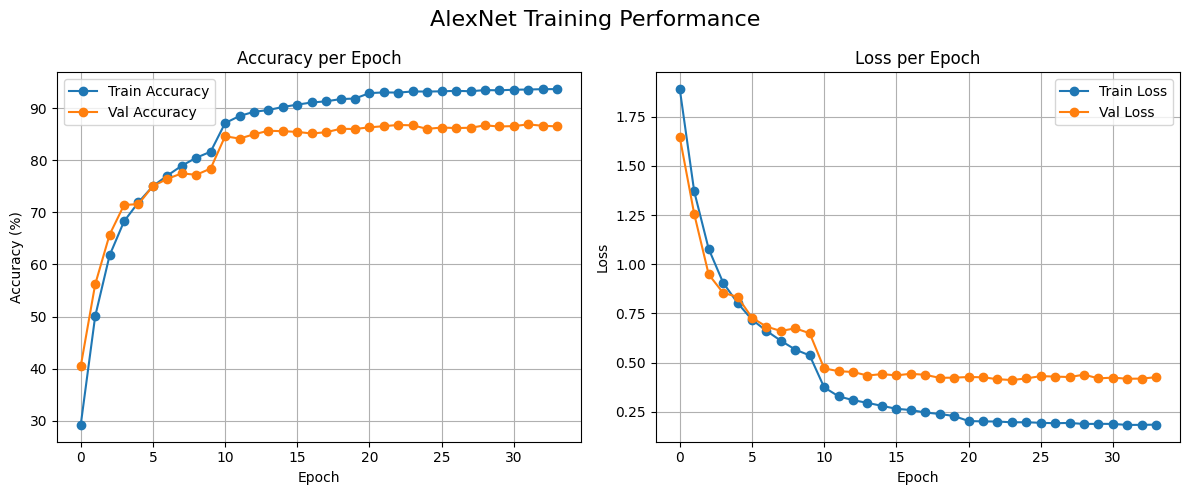

In [29]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle("AlexNet Training Performance", fontsize=16)
plt.tight_layout()
plt.show()

### Evaluation Metrics (Precision / Recall / F1-score)
> [วิธีอ่านค่า Evaluation Metrics (Confusion Matrix / Recall / Precision / F1-score)](https://github.com/morsetechlab/DeepVision-Classical-Models?tab=readme-ov-file#%E0%B8%81%E0%B8%B2%E0%B8%A3%E0%B8%AD%E0%B9%88%E0%B8%B2%E0%B8%99%E0%B8%84%E0%B9%88%E0%B8%B2-evaluation-metrics-precision--recall--f1-score)


In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [31]:
def evaluate_model(model, loader, class_names, title="Confusion Matrix"):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc*100:.2f}%")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [32]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Evaluation on Eval Set:
Accuracy: 86.74%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.87      0.87      0.87       476
  automobile       0.95      0.91      0.93       508
        bird       0.82      0.80      0.81       513
         cat       0.74      0.76      0.75       506
        deer       0.86      0.88      0.87       521
         dog       0.83      0.77      0.80       527
        frog       0.90      0.91      0.90       490
       horse       0.88      0.90      0.89       470
        ship       0.92      0.94      0.93       466
       truck       0.92      0.94      0.93       523

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



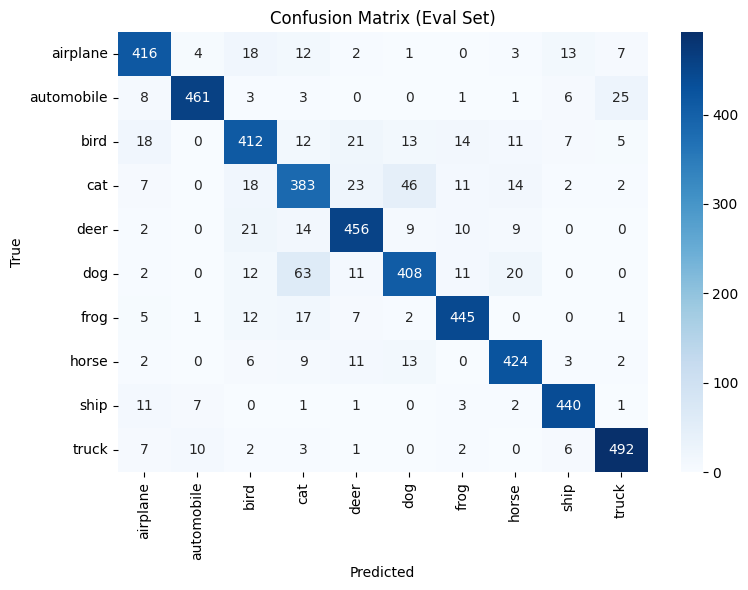

In [33]:
print("Evaluation on Eval Set:")
evaluate_model(model, val_loader, class_names, title="Confusion Matrix (Eval Set)")

## Random Inference

In [34]:
import random

def run_random_inference(model, data_loader, class_names, num_samples=5):
    model.eval()
    images, labels = next(iter(data_loader))

    # สุ่ม index
    idxs = random.sample(range(len(images)), num_samples)
    sampled_images = images[idxs]
    sampled_labels = labels[idxs]

    # ส่งเข้าโมเดล
    with torch.no_grad():
        outputs = model(sampled_images.to(device))
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()

    # แสดงผลลัพธ์
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(idxs):
        img = sampled_images[i]
        label = class_names[sampled_labels[i]]
        pred = class_names[preds[i]]
        correct = label == pred

        # แปลงภาพกลับจาก Normalize
        unnorm = lambda x: x * 0.5 + 0.5
        img = unnorm(img).permute(1, 2, 0).numpy()

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"Pred: {pred}\nTrue: {label}", color='green' if correct else 'red')
        plt.axis('off')

    plt.suptitle("Random Inference from Test Set", fontsize=16)
    plt.tight_layout()
    plt.show()

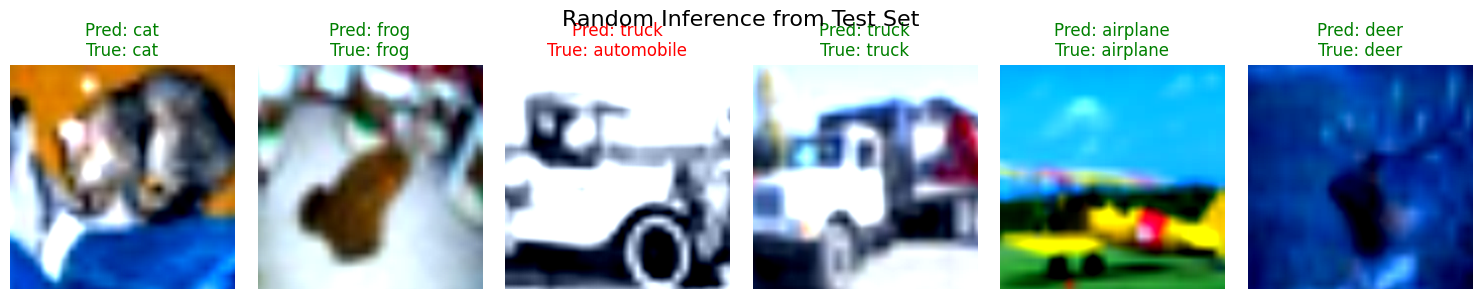

In [35]:
run_random_inference(model, test_loader, class_names, num_samples=6)

## Export Model

In [36]:
!pwd

/content/drive/MyDrive/Colab Notebooks/Classical Deep Learning Implements


In [37]:
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "alexnet_cifar10.pt")
torch.save(model.state_dict(), model_path)
print(f"Model Saved at {model_path}")

Model Saved at saved_models/alexnet_cifar10.pt


## Load Model

In [38]:
model = AlexNet(num_classes=10)
model.load_state_dict(torch.load(f"{project_dir}/saved_models/alexnet_cifar10.pt"))

<All keys matched successfully>